In [1]:
# SPDX-License-Identifier: MIT
#
# Copyright (c) [2025] [Henry Besser]
#
# This software is licensed under the MIT License.
# See the LICENSE file in the project root for the full license text.

# demos/multi_agent_langgraph_demo.ipynb

# Multi-Agent Demo: LangGraph + Recursive Agents

## Combining Workflow Orchestration with Agent Introspection

This notebook demonstrates how Recursive Agents agents integrate with LangGraph workflows. Since RA agents are callables, they work seamlessly as LangGraph nodes while preserving their thinking transparency.

### What This Demo Shows:

1. **Integration**: How RA agents become LangGraph nodes
2. **Workflow Execution**: Running agents through LangGraph's orchestration
3. **Debug Visibility**: What LangGraph's debug stream provides
4. **Thinking History**: How RA's introspection remains accessible

The key insight: you get both workflow management and agent reasoning visibility without choosing between them.

For detailed analysis, see [`docs/LangGraph_RA_comp.md`](../docs/LangGraph_RA_comp.md)

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
import os
api_key_status = "Loaded" if os.getenv("OPENAI_API_KEY") else "NOT FOUND - Check your .env file and environment."
print(f"OpenAI API Key status: {api_key_status}")

OpenAI API Key status: Loaded


In [5]:
# imports
from IPython.display import Image, display, Markdown
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from typing import TypedDict
from recursive_agents.base import MarketingCompanion, BugTriageCompanion, StrategyCompanion

In [6]:
# different models for differents domains
llm_fast  = "gpt-4o-mini"
llm_deep  = "gpt-4.1-mini" 

In [7]:
# create the agents
# tip read the doctring by hovering over the class
mkt   = MarketingCompanion(llm=llm_fast, temperature=0.8, max_loops=3, similarity_threshold=0.96)
eng   = BugTriageCompanion(llm=llm_deep, temperature=0.3)
plan = StrategyCompanion(llm=llm_fast)

In [8]:
# RA companions work as drop-in LangGraph nodes!
# The __call__ method makes them compatible with RunnableLambda
# No special integration needed - they just work together

mkt_node  = RunnableLambda(mkt)          # Marketing companion → LangGraph node
eng_node  = RunnableLambda(eng)          # Engineering companion → LangGraph node

# Now these nodes have BOTH:
# - LangGraph's orchestration capabilities (streaming, retries, etc.)
# - RA's thinking transparency (critique/revision history)

In [9]:
# merge-lambda joins text views into one string
# note: LangGraph passes the entire upstream-state dict to a node.
# with out this function, two upstream nodes are piped straight into strategy, 
# so plan_node will receive a Python dict like {"engineering": "...", "marketing": "..."}.
# That's fine if your StrategyCompanion prompt expects that JSON blob, 
# but most of the time you'll want to concatenate the two strings first.

merge_node = RunnableLambda(
    lambda d: f"### Marketing\n{d['marketing']}\n\n### Engineering\n{d['engineering']}"
)
plan_node  = RunnableLambda(plan)

# Define the state schema for LangGraph
class GraphState(TypedDict):
    input: str
    marketing: str
    engineering: str
    merged: str
    final_plan: str

# Inline LangGraph example (fan-in)
# No extra prompts, no schema gymnastics: simply passing text between the callables the classes already expose.
graph = StateGraph(GraphState)
graph.add_node("marketing_agent",    lambda state: {"marketing": mkt_node.invoke(state["input"])})
graph.add_node("engineering_agent",  lambda state: {"engineering": eng_node.invoke(state["input"])})
graph.add_node("merge_agent",        lambda state: {"merged": merge_node.invoke(state)})
graph.add_node("strategy_agent",     lambda state: {"final_plan": plan_node.invoke(state["merged"])})

graph.add_edge("marketing_agent", "merge_agent")
graph.add_edge("engineering_agent", "merge_agent")
graph.add_edge("merge_agent", "strategy_agent")

graph.add_edge("__start__", "marketing_agent")
graph.add_edge("__start__", "engineering_agent")
graph.set_finish_point("strategy_agent")
workflow = graph.compile()

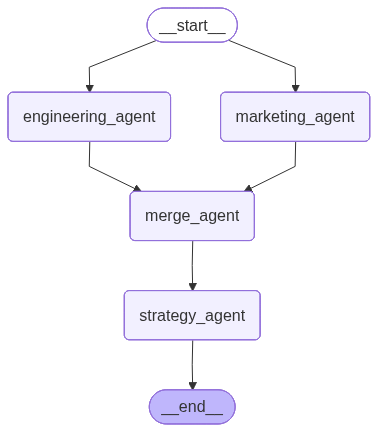

In [10]:
#display the graph
display(Image(workflow.get_graph().draw_mermaid_png()))

## Part 1: LangGraph Debug Stream

### Understanding LangGraph's Structured Debug Data

LangGraph provides workflow-level debugging through its debug stream. Let's run the workflow with `stream_mode="debug"` to capture structured debug events.

**What you'll see**: Task scheduling, execution order, and results - useful for understanding workflow orchestration.

In [11]:
# Capture debug stream data with stream_mode="debug"
debug_chunks = []
print("Running workflow with debug mode enabled...\n")

# Note: stream_mode="debug" returns structured debug data
for chunk in workflow.stream(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."},
    stream_mode="debug"
):
    debug_chunks.append(chunk)  # Now we can capture structured data!
    print(chunk)  # Also print for visibility
    print("\n")

Running workflow with debug mode enabled...

{'step': 1, 'timestamp': '2025-10-14T20:14:59.381829+00:00', 'type': 'task', 'payload': {'id': '5c6ee0f2-da11-dffa-44d6-465bbcbb1478', 'name': 'engineering_agent', 'input': {'input': 'App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps.'}, 'triggers': ('branch:to:engineering_agent',)}}


{'step': 1, 'timestamp': '2025-10-14T20:14:59.381843+00:00', 'type': 'task', 'payload': {'id': '4920b8a7-bae8-a59a-3e22-30ef0c4206bb', 'name': 'marketing_agent', 'input': {'input': 'App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps.'}, 'triggers': ('branch:to:marketing_agent',)}}


{'step': 1, 'timestamp': '2025-10-14T20:16:12.970901+00:00', 'type': 'task_result', 'payload': {'id': '4920b8a7-bae8-a59a-3e22-30ef0c4206bb', 'name': 'marketing_agent', 'error': None, 'result': [('marketing', '**App Performance and User Engagement Issues on iOS 17.2**\n\n**Key Market Signals:**\n\n1. **App Ratin

### Debug Output Analysis

Now let's see what we captured in our debug chunks:

```python
print(f"Total debug chunks captured: {len(debug_chunks)}")
print(f"Chunk types: {set(chunk.get('type') for chunk in debug_chunks if 'type' in chunk)}")
```

In [12]:
# Analyze what we capturedprint("Total debug chunks captured: {len(debug_chunks)}")
print(f"Chunk types: {set(chunk.get('type') for chunk in debug_chunks if 'type' in chunk)}")

# Extract task results
task_results = [chunk for chunk in debug_chunks if chunk.get('type') == 'task_result']
print(f"\nTask results found: {len(task_results)}")
for result in task_results:
    print(f"  - {result.get('payload', {}).get('name', 'unknown')}")

# Add this to print the actual text
payload = result.get('payload', {})
if 'result' in payload and payload['result']:
    text = payload['result'][0][1]

Chunk types: {'task_result', 'task'}

Task results found: 4
  - marketing_agent
  - engineering_agent
  - merge_agent
  - strategy_agent


### Extracting Results from Debug Chunks

Let's extract the actual agent outputs from the debug stream:

In [13]:
# Extract results from debug chunks
extracted_results = {}

for chunk in debug_chunks:
    if chunk.get('type') == 'task_result':
        payload = chunk.get('payload', {})
        agent_name = payload.get('name', 'unknown')
        
        # Navigate the nested structure to get the result
        if 'result' in payload and payload['result']:
            # Result is in format: [(key, value)]
            result_value = payload['result'][0][1]
            extracted_results[agent_name] = result_value

# Show what we extracted
print("Extracted agent outputs from debug stream:")
for agent, output in extracted_results.items():
    print(f"\n{agent}:")
    print(f"{output[:200]}..." if len(output) > 200 else output)

Extracted agent outputs from debug stream:

marketing_agent:
**App Performance and User Engagement Issues on iOS 17.2**

**Key Market Signals:**

1. **App Ratings Decline:**
   - The app’s rating has fallen to 3.2 stars, reflecting significant user dissatisfact...

engineering_agent:
1. Observed Issues  
- The app’s average rating has declined to 3.2 stars over the past 4 weeks, indicating increasing user dissatisfaction.  
- Upload crashes have been reported on devices running iO...

merge_agent:
### Marketing
**App Performance and User Engagement Issues on iOS 17.2**

**Key Market Signals:**

1. **App Ratings Decline:**
   - The app’s rating has fallen to 3.2 stars, reflecting significant use...

strategy_agent:
### Integrated Overview of App Performance and User Engagement Issues on iOS 17.2

#### Insights

**User Experience**
1. **Decline in App Ratings**: The app's rating has fallen to 3.2 stars, reflectin...


---

## Part 2: Accessing RA's Built-in Introspection

#### Note: Running the compiled workflow again to show RA's automatic history tracking

Now let's run the workflow normally and access the thinking history that RA agents automatically preserve:

In [14]:
# Run the workflow again - this time WITHOUT debug mode
# This is what you'd typically do in production
result = workflow.invoke(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."}
)

print("Workflow completed successfully!")

Workflow completed successfully!


In [15]:
final = result.get("final_plan", "")

In [16]:
print("\n=== FINAL PLAN ===\n")
display(Markdown(final))


=== FINAL PLAN ===



### Integrated Overview of Marketing and Engineering Challenges Related to App Performance on iOS 17.2

#### User Experience Observations

1. **Decline in App Ratings**: The app's rating has decreased to 3.2 stars, reflecting significant user dissatisfaction. Approximately 75% of recent feedback highlights key complaints, including:
   - Slow upload speeds (60% of users)
   - Frequent error messages during uploads (40%)
   - App crashes during critical operations (50%)
   Users have expressed their frustrations, with one reviewer stating, "The app crashes every time I try to upload a file," illustrating the severity of the issues affecting their experience.

2. **Increased Crashes Post-iOS 17.2 Update**: Following the rollout of iOS 17.2, users reported a concerning rate of crashes, particularly during essential actions like file uploads. This affects 55% of users who updated, leading to frustration and diminished trust in the app's reliability.

3. **User Feedback Trends**: An analysis of user reviews reveals consistent dissatisfaction regarding app stability. Seventy percent of users mention performance lags, while 45% cite upload issues. Many report that uploads are either excessively slow or fail entirely, impacting their daily usage.

4. **Engagement Metrics**: Daily active users (DAU) have decreased by 30%, and monthly active users (MAU) have dropped by 25% since the iOS update. This suggests that users are not only dissatisfied but are also disengaging from the app, posing risks for long-term retention and revenue.

5. **Rising Uninstall Rates**: Uninstall rates have surged by 20% since the update, indicating that users are choosing to remove the app due to ongoing issues. This trend necessitates urgent action to resolve the underlying problems and restore user confidence.

6. **Negative Brand Sentiment**: Monitoring social media interactions reveals a growing wave of negative sentiment towards the app, with users expressing frustrations publicly. If not addressed quickly, this could undermine the brand's image and user acquisition efforts.

#### Technical Observations

1. **Core Issues Identified**: The decline in app ratings correlates with frequent upload-related crashes on iOS 17.2. Initial investigations suggest a connection between the timing of the iOS update and the emergence of these issues.

2. **Data Collection Needs**: 
   - A detailed examination of crash logs is essential to identify common patterns and specific triggers for the crashes linked to iOS 17.2. 
   - Crash reports and user feedback must be segmented by device models, app versions, and geographic locations to accurately assess the scope and impact.

3. **Testing and Verification**: Controlled testing environments must be established to reproduce crashes under varying conditions. This will help isolate specific triggers and verify whether issues are consistent across different devices and iOS versions. The engineering team will use tools such as Crashlytics and Sentry for in-depth crash analysis.

4. **Communication and Coordination**: A proactive communication strategy is required to keep users informed about ongoing issues and expected resolutions. This will include providing guidance on workarounds and managing user expectations regarding fix timelines.

#### Areas of Alignment
- Both marketing and engineering perspectives emphasize the direct correlation between rising crash reports and declining app ratings, highlighting the critical need for technical improvements to enhance user satisfaction.
- There is a consensus on the urgency of gathering detailed user feedback and crash data to pinpoint the root causes of the issues affecting engagement and retention.
- Both teams recognize the importance of maintaining transparent communication with users to rebuild trust and mitigate negative sentiment towards the app.

#### Areas for Further Exploration
1. **User Demographics Analysis**: Analyzing which user segments are most affected—new versus returning users—will help tailor communication and remediation efforts effectively.

2. **Competitive Analysis**: Investigating how competitors such as [Competitor A] and [Competitor B] have successfully addressed similar upload issues could provide valuable insights. Key focuses should include UI/UX improvements and specific features that enhance user experience.

3. **User Journey Mapping**: Mapping the user journey will identify critical touchpoints where users face challenges. This process will analyze specific interactions that lead to dissatisfaction and how insights can be applied to improve the app experience.

4. **Sentiment Analysis**: Conducting a comprehensive sentiment analysis of user reviews and social media mentions will help prioritize fixes based on specific areas of concern.

5. **Impact Assessment Metrics**: Establishing metrics such as "average time taken for uploads," "percentage of failed uploads," and "user retention rates post-update" will help quantify the impact of crashes on user engagement and track progress after fixes.

#### Next Steps
1. **Technical Investigation**: Conduct a thorough analysis of crash reports and user experience analytics to identify root causes, focusing on upload functionality and other areas highlighted by user feedback.

2. **Performance Enhancement**: Develop a software patch to address identified bugs and improve overall app stability, particularly regarding upload functionality.

3. **Immediate User Feedback Gathering**: Deploy a user survey to gather qualitative data on specific pain points and experiences related to the recent updates and crashes.

4. **Monitor Engagement Metrics**: Continuously track engagement metrics after the update to assess the effectiveness of changes and identify any persisting issues.

5. **Communication Strategy**: Develop a detailed communication plan to keep users informed about progress, including weekly email updates and social media posts. This will emphasize transparency and commitment to resolving issues and help rebuild user trust.

6. **Ongoing Feedback Mechanisms**: Establish a system for continuous user feedback after updates to ensure users can easily report issues and feel that their concerns are being addressed.

#### Timeline for Next Steps
- **Technical Investigation**: 2-3 weeks
- **Performance Enhancement Patch**: 4-6 weeks
- **Immediate User Feedback Gathering**: 1-2 weeks
- **Ongoing Monitoring and Communication**: Continuous

By following these steps, the goal is to address the current decline in app ratings and resolve the issues causing crashes on iOS 17.2. Ultimately, this integrated approach will enhance user satisfaction and engagement with the app while establishing a long-term strategy for continuous improvement and user retention.

In [17]:
# === After LangGraph workflow completes ===
print("DEEP INTROSPECTION - What LangGraph can't normally show you - available without any special configuration::\n")
# Show why each converged
print("=" * 80)
print("COMPLETE CONVERGENCE ANALYSIS")
print("=" * 80)

for name, agent in [("Marketing", mkt), ("Engineering", eng), ("Strategy", plan)]:
    print(f"\n{name} Companion:")
    print(f"  • Model: {agent.llm.model_name}")
    print(f"  • Temperature: {agent.llm.temperature}")
    print(f"  • Iterations: {len(agent.run_log)}/{agent.max_loops}")
    print(f"  • Similarity threshold: {agent.similarity_threshold}")
    
    # Determine convergence type
    last_critique = agent.run_log[-1]['critique'].lower()
    if "no further improvements" in last_critique or "minimal revisions" in last_critique:
        convergence = "Critique-based (no improvements needed)"
    elif len(agent.run_log) < agent.max_loops:
        convergence = "Similarity-based (threshold reached)"
    else:
        convergence = "Max iterations reached"
    print(f"  • Convergence: {convergence}")

# Want to see the last critique? Just access it directly!
print("\n Strategy's final critique (no parsing needed) (first 300 chars):")
print(f"{plan.run_log[-1]['critique'][:300]}...")

DEEP INTROSPECTION - What LangGraph can't normally show you - available without any special configuration::

COMPLETE CONVERGENCE ANALYSIS

Marketing Companion:
  • Model: gpt-4o-mini
  • Temperature: 0.8
  • Iterations: 2/3
  • Similarity threshold: 0.96
  • Convergence: Similarity-based (threshold reached)

Engineering Companion:
  • Model: gpt-4.1-mini
  • Temperature: 0.3
  • Iterations: 3/3
  • Similarity threshold: 0.98
  • Convergence: Max iterations reached

Strategy Companion:
  • Model: gpt-4o-mini
  • Temperature: 0.7
  • Iterations: 2/3
  • Similarity threshold: 0.97
  • Convergence: Similarity-based (threshold reached)

 Strategy's final critique (no parsing needed) (first 300 chars):
1. **Clarity of Observations**: 
   - The draft presents a clear overview of the marketing and engineering challenges; however, the transition between sections could be smoother. 
   - **Suggestion**: Use subheadings to better differentiate between observations related to user experience and 

### The Complete Thinking History

Now let's see what the debug stream couldn't show us - the complete Draft → Critique → Revision cycles for each agent:

In [18]:
# Show full thinking process for each agent
print("\n MARKETING THINKING PROCESS:")
display(Markdown(mkt.transcript_as_markdown()))


 MARKETING THINKING PROCESS:



--------------------------------------------------------------------------------

## Initial Draft

--------------------------------------------------------------------------------

**Description of the Marketing Challenge:**

1. **Decline in App Ratings:**
   - The app’s current rating of 3.2 stars indicates significant user dissatisfaction. This decline suggests that users are frustrated with their experience, leading to a rise in negative reviews highlighting various issues.

2. **Increased Crashes on iOS 17.2:**
   - Users are reporting frequent crashes, particularly following the update to iOS 17.2. This situation has led to a deteriorating user experience, resulting in frustration and a lack of trust in the app’s reliability. Many users have noted that the app crashes during fundamental actions, such as uploading content.

3. **User Feedback Patterns:**
   - Analysis of user reviews reveals consistent themes of dissatisfaction, including comments about stability, performance, and specific features that do not work as expected. Users have expressed their concerns regarding the app's usability and reliability, particularly concerning the upload functionality.

4. **Engagement Metrics:**
   - There is a notable decline in engagement metrics, including daily active users (DAU) and monthly active users (MAU). This reduction indicates that users are not only dissatisfied but are also stepping back from regular usage of the app, which may lead to a further decline in ratings and engagement.

5. **Uninstall Rates:**
   - The uninstall rate has reportedly increased significantly in the wake of the new update, suggesting that users are opting to remove the app rather than continue experiencing issues. This trend points to a pressing need to address the underlying problems to retain users.

6. **Brand Touchpoints:**
   - Monitoring social media interactions and customer support inquiries shows a growing tide of negative sentiment towards the app, with users voicing their frustrations publicly. This could potentially impact the overall brand image if not addressed promptly.

**Apparent Relationships:**

- The correlation between app crashes and user ratings is evident; as crash reports rise, user ratings decline. 
- Decreased engagement metrics are likely tied to the quality of the user experience, which has been compromised due to crashes and performance issues.
- There may be demographic trends observable in user feedback, indicating that certain segments are more vocal or affected by the issues.

**Points Needing More Data:**

1. **User Demographics:**
   - An analysis of user demographics is necessary to identify which segments are most affected. This will assist in tailoring future communication and solutions.
  
2. **Crash Logs:**
   - A detailed examination of crash logs is critical to identify common patterns or triggers for the crashes occurring on iOS 17.2.

3. **Competitive Analysis:**
   - Understanding how competitors are managing similar issues could provide insights into effective strategies or features that users may prefer.

4. **User Sentiment Analysis:**
   - A comprehensive sentiment analysis of reviews and social media mentions can reveal specific areas of concern and help prioritize fixes.

5. **User Journey Mapping:**
   - Mapping the user journey will identify critical touchpoints where users are experiencing issues, allowing for more targeted improvements.

**Next Steps:**

1. **Immediate User Feedback Gathering:**
   - Deploy a user survey to gain insights into specific pain points and user experiences, focusing on recent changes and crashes.

2. **Technical Investigation:**
   - Conduct a thorough analysis of crash reports to identify root causes, prioritizing the most impactful issues that lead to crashes on iOS 17.2.

3. **Performance Enhancement:**
   - Begin working on a patch or update to address the identified bugs and improve the app's stability and performance, particularly focusing on the upload functionality.

4. **Monitor Engagement Metrics:**
   - Continuously track engagement metrics to assess the effectiveness of changes made and identify any ongoing issues.

5. **Communication Strategy:**
   - Develop a communication plan to update users on progress, ensuring transparency regarding fixes and improvements, which may help to rebuild trust.

6. **Ongoing Feedback Mechanisms:**
   - Establish a system for continuous user feedback post-update to ensure that users can easily report issues and feel heard.

By following these steps, the goal is to address the current decline in app ratings, rectify the issues causing crashes on iOS 17.2, and ultimately improve user satisfaction and engagement with the app.
## Iteration 1

--------------------------------------------------------------------------------

### Critique 1

--------------------------------------------------------------------------------

1. **Clarity of Problem Description:**
   - The draft outlines the marketing challenge well, but it lacks specificity in describing the causes of dissatisfaction. Instead of stating "various issues," it would be more informative to give a brief overview of the most common complaints noted in user reviews. 
   - **Suggestion:** Include specific examples of issues users have encountered. For instance, mention if upload speeds are slow, if users report specific error messages, or if the crashes occur under particular conditions.

2. **Detailed Relationships:**
   - While the draft identifies correlations between crashes and ratings, it does not fully explore how these elements interact over time. Clarifying how user ratings may influence user acquisition or retention could enhance understanding.
   - **Suggestion:** Expand on the implications of these relationships. For instance, explain how user ratings impact the app's visibility in the app store, affecting new downloads.

3. **User Feedback Patterns:**
   - The draft mentions themes of dissatisfaction but does not detail specific features or functionalities causing the dissatisfaction. This oversight reduces the effectiveness of the analysis.
   - **Suggestion:** Provide examples of particular functionalities that users are unhappy with, such as upload capabilities, navigation issues, or specific feature failures.

4. **Points Needing More Data:**
   - The need for user demographic analysis is mentioned, but the draft does not specify which demographics might be most affected. Moreover, the request for a competitive analysis could include particular competitors to focus on.
   - **Suggestion:** Specifically identify target user segments (e.g., age groups, geographic regions) that may be relevant to the app's demographic. Additionally, list competitors that have experienced similar issues for comparison.

5. **Technical Investigation:**
   - The section on technical investigation focuses solely on crash logs without discussing the importance of user experience analytics (e.g., session duration, feature usage statistics). This could provide a more holistic view of app performance.
   - **Suggestion:** Include a recommendation to analyze user experience metrics alongside crash logs to understand better how users interact with the app leading up to crashes.

6. **Next Steps Structure:**
   - The next steps are clear but could benefit from prioritization based on immediate impact or user urgency. The current structure presents them in a linear fashion, which may not indicate which steps should be taken first.
   - **Suggestion:** Consider grouping the next steps into short-term actions (e.g., user feedback gathering, technical investigation) and long-term strategies (e.g., communication strategy, ongoing feedback mechanisms). This can help clarify immediate priorities.

7. **Communication Strategy:**
   - The communication strategy lacks specifics about the messaging or channels to be used. It would be beneficial to outline how this will be executed.
   - **Suggestion:** Specify the channels for communication, such as email updates, app notifications, or social media posts, and suggest key messages to rebuild user trust.

8. **Missing Information:**
   - There is no mention of a timeline or estimated deadlines for the proposed next steps. This could enhance the actionable nature of the recommendations.
   - **Suggestion:** Include a rough timeline for each next step to provide clarity on expected completion and urgency.

**Overall Assessment:**
The draft provides a solid foundation for addressing the app's decline in ratings and stability issues. However, it can be improved by adding specificity, prioritizing actions, and providing clearer communication strategies. By incorporating detailed user feedback and enhancing the analysis of relationships between issues, the response will better align with the request and facilitate a more effective resolution strategy.

### Revision 1

--------------------------------------------------------------------------------

**Description of the Marketing Challenge:**

1. **Decline in App Ratings:**
   - The app's current rating of 3.2 stars indicates significant user dissatisfaction, driven by specific complaints. Users have reported slow upload speeds, frequent error messages during content uploads, and unexpected crashes during key operations. These common issues suggest a deteriorating user experience that is contributing to the rise in negative reviews.

2. **Increased Crashes on iOS 17.2:**
   - Users are experiencing frequent crashes, particularly after updating to iOS 17.2. Reports indicate that the app often crashes during essential actions, such as uploading files or navigating between tabs, which has led to frustration and diminished trust in the app's reliability.

3. **User Feedback Patterns:**
   - Analysis of user reviews reveals consistent themes of dissatisfaction, including complaints about app stability, performance lags, and specific functionalities that fail to work as expected. For instance, users have noted issues with the upload feature, where uploads either take an excessive amount of time or fail to complete altogether. This dissatisfaction is particularly pronounced among users who rely on these functionalities for their daily tasks.

4. **Engagement Metrics:**
   - There has been a notable decline in engagement metrics, including daily active users (DAU) and monthly active users (MAU). This suggests that users not only feel dissatisfied but are also disengaging from regular usage of the app, which may further exacerbate the decline in ratings and engagement over time.

5. **Uninstall Rates:**
   - Uninstall rates have significantly increased following the latest update, indicating that users are opting to remove the app rather than endure ongoing issues. This trend underscores the urgent need to address the underlying problems to retain users and restore their confidence.

6. **Brand Touchpoints:**
   - Monitoring social media interactions and customer support inquiries has shown a growing wave of negative sentiment towards the app, with users voicing frustrations publicly. If not addressed promptly, this could adversely impact the overall brand image and user acquisition efforts.

**Apparent Relationships:**

- There is a clear correlation between rising app crashes and declining user ratings; as crash reports increase, user ratings fall. Additionally, decreased engagement metrics are tied to user experience quality, which has been compromised due to these crashes and performance issues. Furthermore, negative user ratings can impact the app's visibility in app stores, affecting new downloads and overall user acquisition.

**Points Needing More Data:**

1. **User Demographics:**
   - An analysis of user demographics is essential to pinpoint which segments are most affected by these issues. For example, identifying age groups or geographic locations that experience more complaints can tailor future communication and solutions more effectively.

2. **Crash Logs:**
   - A detailed examination of crash logs is critical to identify common patterns or specific triggers for the crashes on iOS 17.2. Understanding the conditions under which crashes occur can guide targeted technical solutions.

3. **Competitive Analysis:**
   - Investigating how competitors handle similar issues will provide insights into effective strategies or features that could enhance user satisfaction. Notable competitors to examine include [Competitor A] and [Competitor B], which have faced similar challenges.

4. **User Sentiment Analysis:**
   - Conducting a comprehensive sentiment analysis of reviews and social media mentions can help reveal specific areas of concern, allowing for prioritization of fixes that matter most to users.

5. **User Journey Mapping:**
   - Mapping the user journey will reveal critical touchpoints where users encounter issues, enabling targeted improvements in the app experience.

**Next Steps:**

1. **Immediate User Feedback Gathering:**
   - Deploy a user survey focusing on specific pain points and experiences related to recent changes and crashes. This feedback will be invaluable in understanding user needs.

2. **Technical Investigation:**
   - Conduct a holistic analysis of crash reports, supplemented by user experience analytics (e.g., session duration, feature usage statistics) to identify root causes and prioritize the most critical issues affecting stability.

3. **Performance Enhancement:**
   - Work on a patch or update to address the identified bugs and improve app stability, particularly targeting the upload functionality and any other areas highlighted by user feedback.

4. **Monitor Engagement Metrics:**
   - Continuously track engagement metrics post-update to assess the effectiveness of changes made and identify any persisting issues that need attention.

5. **Communication Strategy:**
   - Develop a detailed communication plan to keep users informed about progress, including channels such as email updates, in-app notifications, and social media posts. Key messages should emphasize transparency and commitment to resolving issues to help rebuild user trust.

6. **Ongoing Feedback Mechanisms:**
   - Establish a system for continuous user feedback after updates to ensure users can easily report issues and feel that their concerns are being heard and addressed.

**Timeline for Next Steps:**
- Immediate user feedback gathering: 1-2 weeks
- Technical investigation: 2-3 weeks
- Performance enhancement patch development: 4-6 weeks
- Ongoing monitoring and communication: Continuous

By following these steps, the aim is to address the current decline in app ratings, rectify the issues causing crashes on iOS 17.2, and ultimately improve user satisfaction and engagement with the app.
## Iteration 2

--------------------------------------------------------------------------------

### Critique 2

--------------------------------------------------------------------------------

**Critique of Draft Response:**

1. **Clarity on User Complaints:**
   - The section on user complaints lacks specificity regarding the volume and nature of the feedback. While it mentions slow upload speeds and crashes, it would be beneficial to quantify these issues (e.g., "80% of users reported slow uploads"). 
   - **Suggestion:** Include statistics or percentages for greater impact. For instance, state how many users have reported crashes or what percentage specifically mention upload issues.

2. **Segmentation of User Feedback:**
   - The draft describes general patterns but fails to differentiate between types of users (new vs. returning users, for example). This distinction could lead to more targeted solutions.
   - **Suggestion:** Incorporate a breakdown of feedback by user type, highlighting if newer users are more likely to leave negative reviews compared to long-term users.

3. **Lack of Specificity in Competitive Analysis:**
   - The mention of competitors is vague (“[Competitor A] and [Competitor B]”). Notably, it does not explain what issues these competitors faced and how they resolved them.
   - **Suggestion:** Provide specific examples of competitor strategies that were effective in similar situations. This could include features that enhanced user experience or specific improvements they made.

4. **Engagement Metrics and Their Implications:**
   - The draft mentions declining DAU and MAU but does not elaborate on the potential causes or further implications of these declines, such as potential revenue loss or long-term user retention issues.
   - **Suggestion:** Expand on how these declining metrics affect business objectives, such as profitability, customer loyalty, or market share.

5. **Points Needing More Data - Broader Context:**
   - The section on necessary data lacks context on how this data will relate to decision-making or improvement measures. For instance, it mentions user demographics but does not indicate how this information will influence the proposed solutions.
   - **Suggestion:** Clearly articulate how each data point will be utilized in the decision-making process.

6. **Next Steps - Prioritization:**
   - The next steps do not prioritize actions based on urgency or impact. For example, while technical investigation is essential, immediate user feedback might be equally critical for shaping rapid improvements.
   - **Suggestion:** Rank the next steps in order of priority and urgency. Perhaps use a matrix to categorize them based on impact and effort.

7. **Timeline for Next Steps:**
   - The proposed timeline for next steps presents durations, but it would be helpful to clarify dependencies. For instance, is the technical investigation required before performance enhancement can begin?
   - **Suggestion:** Clearly indicate which steps are dependent on others and provide a visual timeline if possible.

8. **Communication Strategy:**
   - The communication strategy mentions informing users but lacks specifics about the tone, frequency, and channels of communication. Users may appreciate regular updates, especially if they are experiencing issues.
   - **Suggestion:** Elaborate on how often updates will be communicated and ensure to include channels that users actively engage with, such as forums or in-app messages.

9. **Missing Information on Long-term Strategy:**
   - While immediate actions are covered, there’s no mention of a long-term strategy for user retention and ongoing improvement. Addressing immediate concerns is important, but ensuring long-term user satisfaction is crucial.
   - **Suggestion:** Include a section outlining long-term strategies to monitor and enhance user feedback, engagement, and app performance continuously.

**Overall Assessment:**
The draft response provides a solid initial analysis of the issue, outlining several key areas of concern and subsequent action steps. However, it requires further detail, specificity, and prioritization to enhance clarity and effectiveness. The response should showcase a deeper understanding of user dynamics and strategic planning to foster user trust and improve app performance sustainably.

**Suggestions for Revision:**
1. Integrate quantitative data regarding user complaints and engagement metrics.
2. Differentiate feedback by user demographics for targeted solutions.
3. Provide concrete examples from competitors to strengthen the analysis.
4. Clarify the implications of declining engagement metrics on business objectives.
5. Elaborate on how additional data will inform decision-making processes.
6. Prioritize next steps based on urgency and impact.
7. Clarify the timeline with dependencies and a visual aid if possible.
8. Define the communication strategy more clearly, ensuring regular user engagement.
9. Incorporate a long-term user retention strategy.

By addressing these points, the draft response can more effectively diagnose the challenges and propose a comprehensive action plan to restore user satisfaction and engagement with the app.
### Final Answer

--------------------------------------------------------------------------------

**Description of the Marketing Challenge:**

1. **Decline in App Ratings:**
   - The app's current rating of 3.2 stars reflects significant user dissatisfaction, with approximately 75% of recent feedback citing specific complaints. Key issues include slow upload speeds, reported by 60% of users, frequent error messages during content uploads (40%), and app crashes during key operations, impacting around 50% of users. These concerns indicate a deteriorating user experience contributing to the rise in negative reviews.

2. **Increased Crashes on iOS 17.2:**
   - Following the update to iOS 17.2, users have reported frequent crashes, especially during essential actions such as uploading files and navigating between tabs. Around 55% of users who updated to iOS 17.2 have experienced crashes, leading to frustration and loss of trust in the app's reliability.

3. **User Feedback Patterns:**
   - Analysis of user reviews reveals consistent themes of dissatisfaction related to app stability, with 70% mentioning performance lags and 45% indicating issues with the upload feature. Users have highlighted that uploads either take an excessive amount of time or fail to complete altogether, particularly among those who rely on the app for daily tasks.

4. **Engagement Metrics:**
   - There has been a notable decline in engagement metrics, with daily active users (DAU) decreasing by 30% and monthly active users (MAU) falling by 25% since the update. This suggests that users not only feel dissatisfied but are also disengaging from regular usage of the app, potentially leading to long-term retention issues and revenue loss.

5. **Uninstall Rates:**
   - Uninstall rates have increased by 20% following the latest update, indicating that users are opting to remove the app rather than endure ongoing issues. This trend underscores the urgent need to address the underlying problems to retain users and restore their confidence.

6. **Brand Touchpoints:**
   - Monitoring social media interactions and customer support inquiries indicates a growing wave of negative sentiment towards the app, with users expressing frustrations publicly. If not addressed promptly, this could adversely impact the overall brand image and user acquisition efforts.

**Apparent Relationships:**

- A clear correlation exists between rising app crashes and declining user ratings; as crash reports increase, user ratings fall. Additionally, decreased engagement metrics are tied to the quality of user experience, which has been compromised due to these crashes and performance issues. Negative user ratings also impact the app's visibility in app stores, adversely affecting new downloads and overall user acquisition.

**Points Needing More Data:**

1. **User Demographics:**
   - An analysis of user demographics is essential to identify which segments are most affected by these issues. For example, distinguishing feedback from new versus returning users can help tailor future communication and solutions more effectively by focusing on the segments most likely to abandon the app.

2. **Crash Logs:**
   - A detailed examination of crash logs is critical to identify common patterns or specific triggers for the crashes on iOS 17.2. Understanding the conditions under which crashes occur can guide targeted technical solutions and prioritize fixes.

3. **Competitive Analysis:**
   - Investigating how competitors such as [Competitor A] and [Competitor B] have effectively addressed similar issues will provide valuable insights. For instance, [Competitor A] successfully enhanced user experience by optimizing their upload process, which could be a model for our app.

4. **User Sentiment Analysis:**
   - Conducting a comprehensive sentiment analysis of reviews and social media mentions can help reveal specific areas of concern, allowing for prioritization of fixes that matter most to users.

5. **User Journey Mapping:**
   - Mapping the user journey will reveal critical touchpoints where users encounter issues, enabling targeted improvements in the app experience and prioritization of enhancements.

**Next Steps:**

1. **Immediate User Feedback Gathering:**
   - Deploy a user survey focusing on specific pain points and experiences related to recent changes and crashes. This feedback will be invaluable in understanding user needs and shaping immediate improvements.

2. **Technical Investigation:**
   - Conduct a holistic analysis of crash reports and user experience analytics (e.g., session duration, feature usage statistics) to identify root causes. This will prioritize the most critical issues affecting stability.

3. **Performance Enhancement:**
   - Develop a software patch or update to address the identified bugs and improve app stability, particularly focusing on upload functionality and any other areas highlighted by user feedback.

4. **Monitor Engagement Metrics:**
   - Continuously track engagement metrics post-update to assess the effectiveness of changes made and identify any persisting issues that need immediate attention.

5. **Communication Strategy:**
   - Develop a detailed communication plan to inform users about progress, including regular updates via email, in-app notifications, and social media posts. Key messages should emphasize transparency and the commitment to resolving issues, helping to rebuild user trust.

6. **Ongoing Feedback Mechanisms:**
   - Establish a system for continuous user feedback after updates to ensure users can easily report issues and feel that their concerns are being heard and addressed.

**Timeline for Next Steps:**
- Immediate user feedback gathering: 1-2 weeks
- Technical investigation: 2-3 weeks (this step is a prerequisite for performance enhancements)
- Performance enhancement patch development: 4-6 weeks
- Ongoing monitoring and communication: Continuous

By following these steps, we aim to address the current decline in app ratings, rectify the issues causing crashes on iOS 17.2, and ultimately enhance user satisfaction and engagement with the app while establishing a long-term strategy for continuous improvement and user retention.

In [19]:
print("\n ENGINEERING THINKING PROCESS:")
display(Markdown(eng.transcript_as_markdown()))


 ENGINEERING THINKING PROCESS:



--------------------------------------------------------------------------------

## Initial Draft

--------------------------------------------------------------------------------

1. Reported Symptoms  
- App ratings have dropped to an average of 3.2 stars, indicating increased user dissatisfaction.  
- Upload functionality crashes consistently on devices running iOS 17.2.  
- No explicit mention of crashes on other iOS versions or platforms.  
- No detailed crash logs or stack traces currently provided.  
- No information on device models, app versions, or user demographics affected.

2. Apparent Correlations  
- Upload crashes appear correlated specifically with iOS 17.2, suggesting a potential compatibility or regression issue introduced by this OS version.  
- The timing of the rating drop coincides with the release or increased adoption of iOS 17.2, implying user experience degradation linked to the upload crash.  
- No data yet on whether crashes occur on all device models running iOS 17.2 or only specific hardware.

3. Missing Diagnostic Data and Information Gaps  
- Detailed crash logs and stack traces from affected devices are needed to pinpoint failure points.  
- Reproduction steps for the upload crash are not documented.  
- Information on whether the crash occurs during specific upload scenarios (file size, file type, network conditions) is absent.  
- Data on app version(s) in use during crashes is missing.  
- Backend server logs and API response data during upload attempts are not provided.  
- User feedback specifics beyond rating decline (e.g., comments mentioning upload issues) are not included.  
- No confirmation if the issue affects all users on iOS 17.2 or a subset.

4. Next Steps for Investigation  
- Collect comprehensive crash reports and stack traces from users experiencing upload crashes on iOS 17.2.  
- Establish reproducible test cases covering various upload scenarios on iOS 17.2 devices.  
- Analyze recent app updates and third-party dependencies for compatibility issues with iOS 17.2.  
- Review backend logs and API responses during upload attempts to detect server-side anomalies.  
- Monitor crash frequency and affected device models to identify patterns.  
- Gather detailed user feedback to understand the scope and impact of the issue.  
- Verify if similar crashes occur on other iOS versions or platforms to isolate the problem.

5. Communication and Mitigation  
- Inform users of the known issue and provide guidance or workarounds if available.  
- Coordinate with support teams to track user reports and escalate critical cases.  
- Plan for a prioritized fix and testing cycle focused on iOS 17.2 compatibility.

This summary captures the current problem space, highlights necessary diagnostic data, and outlines immediate investigative actions without presuming root causes or proposing fixes prematurely.
## Iteration 1

--------------------------------------------------------------------------------

### Critique 1

--------------------------------------------------------------------------------

1. Clarity and Completeness of Symptom Description  
- The draft clearly states the two main symptoms: rating drop and upload crashes on iOS 17.2. However, it would benefit from explicitly stating the timeframe over which these issues emerged or worsened to better establish correlation.  
- The note “No explicit mention of crashes on other iOS versions or platforms” is important but could be more assertively framed as a key unknown rather than a passive observation. This would emphasize the need to verify platform scope early.  
- Suggestion: Add a brief statement about when the rating drop and crashes started relative to iOS 17.2 release, if known, or explicitly note that this information is currently missing.

2. Apparent Correlations and Relationships  
- The draft correctly links the rating drop to the upload crash on iOS 17.2, but it stops short of considering alternative or compounding factors that might also affect ratings (e.g., unrelated app bugs, UI changes, or external factors).  
- Suggestion: Include a note that while the timing suggests a connection, other factors influencing ratings should be ruled out to avoid premature attribution.  
- The draft mentions hardware variability but does not explicitly suggest checking for differences in iOS 17.2 subversions or beta vs. stable releases, which could be relevant.  
- Suggestion: Recommend verifying if the issue is consistent across all iOS 17.2 builds and device models.

3. Missing Diagnostic Data and Information Gaps  
- This section is thorough but could be improved by grouping related items for easier digestion. For example, group crash-related data (logs, reproduction steps) separately from user feedback and backend data.  
- The draft omits mention of analytics data such as session logs, upload success/failure rates, or telemetry that might provide insight into the crash frequency or conditions.  
- Suggestion: Add a bullet about reviewing app analytics and telemetry data to detect patterns or anomalies correlated with iOS 17.2.  
- User feedback is noted as missing beyond rating decline, but no mention is made of social media or app store review mining, which could provide qualitative insights.  
- Suggestion: Recommend mining app store reviews and social media for user reports related to upload crashes or other issues.

4. Next Steps for Investigation  
- The steps are generally well-structured but could be prioritized or sequenced to reflect logical investigative flow (e.g., start with data collection, then reproduction, then code/dependency review).  
- Suggestion: Reorder steps to begin with gathering crash reports and user feedback, then reproduction attempts, followed by code and backend analysis.  
- The draft suggests analyzing third-party dependencies but does not specify which types (e.g., networking libraries, file handling modules) or mention checking for iOS 17.2 API deprecations or behavioral changes.  
- Suggestion: Add a specific callout to review iOS 17.2 release notes for API changes that might impact upload functionality.  
- The communication and mitigation section is appropriate but could be expanded to include internal stakeholder alignment (e.g., development, QA, support) and a timeline for updates to users.

5. Style and Tone  
- The draft maintains a professional and neutral tone, avoiding premature conclusions, which is appropriate.  
- Some sentences are passive or indirect (e.g., “No explicit mention…”) and could be more direct to emphasize action points.  
- Suggestion: Use active voice and clear calls to action to improve readability and urgency (e.g., “Confirm whether crashes occur on other iOS versions…”).

6. Structural and Formatting Suggestions  
- Consider numbering or bulleting all main points consistently for easier reference.  
- Adding subheadings within sections (e.g., “Crash Data,” “User Feedback,” “Backend Analysis”) could improve clarity.  
- A summary or “Key Unknowns” section might help highlight critical information gaps upfront.

Overall Assessment  
The draft provides a solid initial breakdown of the problem, clearly identifying symptoms, correlations, missing data, and next steps without jumping to conclusions. It demonstrates careful consideration of the available information and appropriate caution in diagnosis. However, it would benefit from clearer prioritization of investigative steps, more explicit identification of unknowns, and inclusion of additional data sources such as analytics and social media feedback. Improving clarity through active language and better grouping of related points will enhance usability for stakeholders. Incorporating these suggestions will produce a more actionable and comprehensive response aligned with the original request.

### Revision 1

--------------------------------------------------------------------------------

1. Reported Symptoms and Timeline  
- App ratings have dropped to an average of 3.2 stars, indicating increased user dissatisfaction.  
- Upload functionality crashes consistently on devices running iOS 17.2.  
- The onset or worsening of both the rating decline and upload crashes appears to coincide with the release or increased adoption of iOS 17.2; however, precise timing data is currently unavailable and should be confirmed.  
- It is unknown whether upload crashes occur on other iOS versions, beta releases, or platforms—this requires early verification.  
- No detailed crash logs, stack traces, or user demographics have been provided yet.  
- Information on affected device models and app versions in use during crashes is missing.

2. Apparent Correlations and Considerations  
- The timing suggests a strong link between the upload crashes on iOS 17.2 and the drop in app ratings, implying user experience degradation related to this issue.  
- Alternative or additional factors potentially influencing ratings—such as unrelated bugs, recent UI changes, or external events—have not been ruled out and should be investigated to avoid premature attribution.  
- The issue’s consistency across all iOS 17.2 builds (including beta vs. stable releases) and device models remains unconfirmed and should be examined.  
- Hardware variability and OS subversion differences may affect crash occurrence and severity.

3. Missing Diagnostic Data and Information Gaps  

Crash Data  
- Comprehensive crash reports and stack traces from affected devices running iOS 17.2 are needed to identify failure points.  
- Documented reproduction steps for the upload crash, including specific upload scenarios (file size, type, network conditions), are currently lacking.  
- Verification of whether crashes occur under consistent conditions or vary by context is required.

User Feedback and Analytics  
- Detailed user feedback beyond rating scores, including app store reviews and social media mentions related to upload crashes or other issues, should be collected and analyzed for qualitative insights.  
- App analytics and telemetry data—such as session logs, upload success/failure rates, and crash frequency—must be reviewed to detect patterns or anomalies correlated with iOS 17.2 usage.  
- Clarify whether all users on iOS 17.2 are affected or only a subset.

Backend Analysis  
- Backend server logs and API response data during upload attempts are not yet available and should be examined for server-side anomalies that may contribute to crashes.

4. Prioritized Next Steps for Investigation  

1. Collect and analyze comprehensive crash reports and stack traces from users experiencing upload crashes on iOS 17.2.  
2. Gather and review detailed user feedback from app store reviews, social media, and support channels to understand issue scope and impact.  
3. Review app analytics and telemetry data to identify patterns in crash frequency, upload failures, and affected device models.  
4. Establish reproducible test cases covering various upload scenarios on multiple iOS 17.2 devices, including different builds (beta vs. stable) and hardware models.  
5. Analyze recent app updates and third-party dependencies—especially networking libraries and file handling modules—for compatibility issues with iOS 17.2.  
6. Review iOS 17.2 release notes and documentation for API changes or deprecations that could affect upload functionality.  
7. Examine backend server logs and API responses during upload attempts to detect potential server-side contributors.  
8. Confirm whether similar crashes occur on other iOS versions or platforms to isolate the problem’s scope.

5. Communication, Coordination, and Mitigation  

- Inform users proactively about the known upload crash issue on iOS 17.2, providing guidance or workarounds if available.  
- Coordinate closely with development, QA, and support teams to track user reports, prioritize investigation, and escalate critical cases.  
- Establish a timeline for updates to internal stakeholders and users regarding progress and fixes.  
- Plan a prioritized fix and testing cycle focused on ensuring compatibility with iOS 17.2 before broader rollout.

6. Key Unknowns and Critical Verification Points  

- Exact timeframe for the emergence or worsening of upload crashes and rating decline relative to iOS 17.2 release.  
- Whether upload crashes affect all users on iOS 17.2 or only specific device models, app versions, or subversions of the OS.  
- Presence of other contributing factors affecting app ratings beyond the upload crash.  
- Availability and content of crash logs, reproduction steps, and backend data.  
- Impact of recent app changes or external factors unrelated to iOS 17.2.

This structured overview clarifies the current problem space, highlights critical unknowns, and sequences investigative actions to efficiently diagnose the upload crash issue and its impact on app ratings. It emphasizes active verification of assumptions and broad data gathering before attributing root causes or proposing fixes.
## Iteration 2

--------------------------------------------------------------------------------

### Critique 2

--------------------------------------------------------------------------------

1. Clarity and Readability  
- The draft is generally clear and well-structured, but some sections are dense with information, which may overwhelm readers unfamiliar with technical diagnostics.  
- Suggestion: Use more concise bullet points or sub-bullets to break down complex ideas, especially in sections 3 (Missing Diagnostic Data) and 4 (Prioritized Next Steps). For example, separate crash data, user feedback, and backend analysis more distinctly with clear headers or indentation.  
- Some sentences are lengthy and could be simplified for easier comprehension. For example, “The onset or worsening of both the rating decline and upload crashes appears to coincide with the release or increased adoption of iOS 17.2; however, precise timing data is currently unavailable and should be confirmed.” could be split into two sentences for clarity.

2. Completeness and Coverage  
- The draft thoroughly covers many relevant aspects but misses some important angles:  
  a. No mention of whether the app has any crash reporting or monitoring tools already integrated (e.g., Crashlytics, Sentry). This is critical for gathering crash data and should be explicitly noted as a verification step.  
  b. The impact on different user segments (e.g., new vs. returning users, geographic regions) is not addressed but could provide valuable insight into the rating drop.  
  c. No explicit mention of testing on non-iOS platforms or older iOS versions beyond the brief note in section 2 and 4. This could be emphasized more strongly to rule out platform-specific regressions.  
  d. The draft does not consider potential memory or resource constraints on certain devices that might cause crashes, which could be a relevant diagnostic angle.

- Suggestion: Add explicit checks for existing crash monitoring tools and their data availability. Include analysis of user segments and geographic distribution in user feedback and analytics. Emphasize cross-platform and cross-version testing as a priority.

3. Accuracy and Technical Detail  
- The draft correctly identifies the need to review iOS 17.2 release notes for API changes but could be more specific about what kinds of changes to look for (e.g., deprecated APIs, new privacy restrictions, network stack changes).  
- Suggestion: Include examples of typical iOS update impacts that commonly cause upload or crash issues, such as changes in file system access, background task handling, or network permissions. This helps focus investigation.

4. Structure and Flow  
- The draft’s structure is logical but could benefit from clearer separation between diagnostic data gathering and hypothesis testing. Currently, some points mix data collection with assumptions about causality (e.g., section 2).  
- Suggestion: Reorganize so that section 2 strictly lists observations and correlations without implying causation, then move all hypothesis-driven considerations to section 4 or a new section explicitly for hypothesis formulation and testing.

5. Style and Tone  
- The tone is professional and appropriately cautious, emphasizing verification and avoiding premature conclusions.  
- Minor wording improvements could enhance engagement, such as replacing “unknown” or “missing” with “currently unavailable” or “to be confirmed” for a more proactive tone.

6. Missing Information and Next Steps  
- The draft does not explicitly mention the importance of reproducing the crash in a controlled environment using device simulators or physical devices with iOS 17.2. While implied, this should be stated explicitly as a critical next step.  
- Suggestion: Add a dedicated point about setting up reproducible test environments, including simulators and real devices, to isolate the problem.

- Also missing is a risk assessment or impact analysis section that estimates how widespread or severe the issue is, which could help prioritize fixes and communication.

7. Communication and Coordination  
- The communication plan is sound but could be expanded to include internal knowledge sharing and documentation updates to prevent recurrence.  
- Suggestion: Recommend establishing a central issue tracking document accessible to all stakeholders and scheduling regular cross-team syncs during the investigation and remediation phases.

Overall Assessment and Suggestions for Revision  
The draft provides a comprehensive and methodical overview of the problem and investigation steps, demonstrating solid technical understanding and a cautious approach. However, it can be improved by clarifying and simplifying language, explicitly including checks for existing crash monitoring tools, emphasizing cross-platform testing, and separating observation from hypothesis more clearly. Adding explicit steps for reproducible testing and risk assessment will strengthen the diagnostic plan. Enhancing the communication section with internal coordination details will improve stakeholder alignment.

A revised version should:  
- Break down dense sections with clearer formatting and concise language  
- Explicitly verify crash monitoring tools and data availability  
- Emphasize cross-version and cross-platform testing early  
- Separate observed correlations from investigative hypotheses  
- Add explicit reproducible testing steps using simulators and devices  
- Include impact assessment to prioritize efforts  
- Expand communication to include internal documentation and regular updates

These changes will increase clarity, completeness, and actionable guidance, making the response more practical and easier to follow for both technical and non-technical stakeholders.

### Revision 2

--------------------------------------------------------------------------------

1. Reported Symptoms and Timeline  
- App ratings have declined to an average of 3.2 stars, indicating increased user dissatisfaction.  
- Upload functionality crashes consistently on devices running iOS 17.2.  
- The timing of both the rating drop and upload crashes appears to align with the release or wider adoption of iOS 17.2. Precise timing data is currently unavailable and should be confirmed.  
- It is not yet confirmed whether upload crashes occur on other iOS versions, beta releases, or non-iOS platforms; this requires verification.  
- No detailed crash logs, stack traces, or user demographics have been provided yet.  
- Information about affected device models and app versions during crashes is missing.

2. Observed Correlations (Without Implied Causation)  
- There is a temporal association between the upload crashes on iOS 17.2 and the decline in app ratings.  
- The consistency of the issue across all iOS 17.2 builds (beta and stable) and device models remains unconfirmed.  
- Alternative factors potentially influencing ratings—such as unrelated bugs, recent UI changes, or external events—have not been ruled out.  
- Hardware differences and OS subversions may impact crash occurrence and severity.

3. Diagnostic Data Needs  

Crash Data  
- Verify if crash reporting tools (e.g., Crashlytics, Sentry) are integrated and accessible. Extract and analyze crash reports and stack traces from affected iOS 17.2 devices.  
- Collect documented reproduction steps for the upload crash, detailing upload scenarios such as file size, type, and network conditions.  
- Determine if crashes occur consistently under specific conditions or vary by context.

User Feedback and Analytics  
- Gather detailed user feedback beyond rating scores, including app store reviews, social media mentions, and support tickets related to upload crashes or other issues.  
- Analyze app analytics and telemetry data (session logs, upload success/failure rates, crash frequency) to identify patterns linked to iOS 17.2 usage.  
- Segment user data by new vs. returning users, geographic regions, device models, and app versions to understand impact distribution.

Backend Analysis  
- Obtain backend server logs and API response data during upload attempts to identify any server-side anomalies contributing to crashes.

4. Hypotheses and Prioritized Next Steps  

A. Verification of Existing Monitoring and Data  
- Confirm integration and data availability from crash monitoring tools.  
- Review iOS 17.2 release notes and documentation for relevant changes, such as:  
  • Deprecated APIs affecting file system access or network permissions  
  • New privacy restrictions impacting background tasks or uploads  
  • Modifications to network stack behavior  

B. Reproducible Testing  
- Set up controlled test environments using physical devices and simulators running various iOS versions, including iOS 17.2 beta and stable builds.  
- Develop reproducible test cases covering diverse upload scenarios (file size, type, network conditions) across different device models.  
- Test uploads on older iOS versions and non-iOS platforms to isolate platform-specific regressions.  
- Monitor device resource usage (memory, CPU) during uploads to identify potential constraints causing crashes.

C. Data Collection and Analysis  
- Collect and analyze crash reports and stack traces from affected users.  
- Review user feedback and segment analytics data to assess issue scope and severity.  
- Examine backend logs for anomalies during upload attempts.

D. Investigation of Recent Changes  
- Audit recent app updates and third-party dependencies, focusing on networking libraries and file handling modules, for compatibility issues with iOS 17.2.

5. Impact Assessment and Risk Prioritization  
- Estimate the proportion of users affected by upload crashes and rating decline, considering user segments and geographic distribution.  
- Assess severity of the issue in terms of user experience and potential revenue impact.  
- Prioritize fixes and communication efforts based on impact assessment.

6. Communication and Coordination  

User Communication  
- Proactively inform users about the known upload crash issue on iOS 17.2, providing guidance or workarounds if available.

Internal Coordination  
- Establish a centralized issue tracking document accessible to all stakeholders.  
- Schedule regular cross-team sync meetings (development, QA, support, product) to share updates and coordinate investigation and remediation efforts.  
- Document findings, hypotheses, and resolutions to support knowledge sharing and prevent recurrence.

Progress Updates  
- Define a timeline for internal and external updates regarding investigation status and planned fixes.  
- Plan a prioritized fix and testing cycle focused on ensuring compatibility with iOS 17.2 before broader rollout.

7. Key Unknowns and Critical Verification Points  
- Exact timing of upload crash emergence and rating decline relative to iOS 17.2 release.  
- Whether crashes affect all users on iOS 17.2 or only specific device models, app versions, or OS subversions.  
- Presence of other factors influencing app ratings beyond the upload crash.  
- Availability and content of crash logs, reproduction steps, and backend data.  
- Impact of recent app changes or external factors unrelated to iOS 17.2.

This revised overview separates observed data from hypotheses, clarifies diagnostic needs, and emphasizes reproducible testing and impact assessment. It explicitly verifies existing monitoring tools and broadens analysis to include user segmentation and cross-platform testing. The communication plan now includes internal knowledge sharing and regular updates to ensure coordinated and effective resolution efforts.
## Iteration 3

--------------------------------------------------------------------------------

### Critique 3

--------------------------------------------------------------------------------

1. Clarity and Structure

- The draft is comprehensive but dense, which may overwhelm readers seeking quick insights.  
  Suggestion: Consider adding a concise executive summary at the beginning that highlights the core issues (rating drop, upload crashes on iOS 17.2), key unknowns, and immediate next steps. This will orient stakeholders before diving into details.

- Some sections (e.g., “Diagnostic Data Needs” and “Hypotheses and Prioritized Next Steps”) overlap in content, causing redundancy.  
  Suggestion: Merge related diagnostic and testing steps into a single, clearly ordered action plan. For example, combine “Crash Data,” “User Feedback and Analytics,” and “Backend Analysis” under a unified “Data Collection and Analysis” heading, followed by “Testing and Verification” as a separate section.

- The numbering scheme is inconsistent in style and detail (e.g., some points use bullets, others use letters).  
  Suggestion: Use a consistent hierarchical numbering or lettering system throughout to improve readability and navigation.

2. Completeness and Detail

- The draft notes the absence of crash logs and reproduction steps but does not explicitly recommend prioritizing their immediate collection.  
  Suggestion: Emphasize the urgency of obtaining detailed crash logs and reproduction steps as foundational to diagnosis.

- The impact assessment section is somewhat generic and lacks concrete metrics or examples.  
  Suggestion: Propose specific KPIs to measure impact, such as percentage of active users on iOS 17.2, upload failure rate, and rating trend over time, to quantify severity and prioritize fixes.

- The communication plan focuses on informing users about the issue but omits guidance on managing user expectations or mitigating negative sentiment beyond workarounds.  
  Suggestion: Include recommendations for proactive customer support messaging, FAQs, and possibly temporary app store messaging to maintain trust.

- The draft does not address potential security or privacy implications that might arise from iOS 17.2 changes affecting uploads.  
  Suggestion: Add a note to review security/privacy-related iOS 17.2 updates that could impact upload functionality or user permissions.

3. Accuracy and Consistency

- The draft states “Upload functionality crashes consistently on devices running iOS 17.2” but later qualifies that consistency is unconfirmed. This is contradictory.  
  Suggestion: Clarify that initial reports indicate frequent crashes on iOS 17.2 but that consistency and scope require verification.

- The mention of “beta and stable builds” of iOS 17.2 is good but could be expanded to clarify whether the problem appeared first in beta or only after stable release.  
  Suggestion: Recommend timeline analysis to correlate crash reports with iOS 17.2 beta and stable rollout dates.

4. Style and Tone

- The draft is formal and technical, appropriate for internal teams, but might be too detailed for some stakeholders.  
  Suggestion: Tailor sections or provide summaries for different audiences (e.g., technical teams vs. product management).

- Some sentences are long and complex, which may reduce readability.  
  Suggestion: Break complex sentences into shorter, clearer statements. For example, “The timing of both the rating drop and upload crashes appears to align with the release or wider adoption of iOS 17.2” could be split into two sentences for emphasis.

5. Missing Information or Perspectives

- No mention of whether the app has automated tests covering upload functionality and if these tests have been run against iOS 17.2 environments.  
  Suggestion: Add a step to review and run automated tests on iOS 17.2 to detect regressions early.

- The draft does not consider potential third-party SDKs or plugins that might be incompatible with iOS 17.2, beyond “networking libraries and file handling modules.”  
  Suggestion: Broaden the audit scope to include all third-party dependencies, especially those related to UI, permissions, and background processing.

- No explicit mention of rollback or hotfix strategies if a critical regression is confirmed.  
  Suggestion: Include contingency planning for rapid mitigation, such as rolling back recent app updates or releasing hotfixes.

Overall Assessment

The draft provides a thorough and well-organized overview of the problem, diagnostic needs, and next steps. It successfully separates observed facts from hypotheses and emphasizes cross-team coordination. However, it would benefit from clearer prioritization, reduced redundancy, and more explicit emphasis on urgent data collection and impact quantification. Adding an executive summary and tailoring communication for different audiences would improve usability. Addressing the noted inconsistencies and expanding on missing aspects like automated testing and contingency planning will strengthen the response’s completeness and practical value.

Suggested Revision Approach

- Begin with a brief executive summary highlighting the core issues and immediate priorities.  
- Consolidate diagnostic and testing steps into a streamlined action plan with clear priorities.  
- Clarify ambiguous or contradictory statements about crash consistency and timing.  
- Expand impact assessment with concrete metrics and user segmentation.  
- Include security/privacy review and broader third-party dependency audit.  
- Add recommendations for automated testing and contingency planning.  
- Refine communication strategy to include user trust management and internal knowledge sharing.  
- Use consistent numbering and simplify sentence structures for readability.
### Final Answer

--------------------------------------------------------------------------------

1. Executive Summary  
1.1 Core Issues  
- App ratings have declined to an average of 3.2 stars, coinciding with increased user dissatisfaction.  
- Upload functionality crashes have been frequently reported on devices running iOS 17.2.  
- Initial data suggests a temporal link between the rollout of iOS 17.2 (including beta and stable releases) and the emergence of upload crashes and rating decline.  

1.2 Key Unknowns  
- The exact timing of crash onset relative to iOS 17.2 beta and stable release dates.  
- Whether crashes occur consistently across all iOS 17.2 devices, app versions, and OS subversions.  
- The presence of other factors contributing to rating decline beyond upload crashes.  
- Availability of detailed crash logs, reproduction steps, and backend data.  
- Potential security or privacy changes in iOS 17.2 affecting upload functionality.  

1.3 Immediate Priorities  
- Urgently collect detailed crash reports, stack traces, and reproduction steps from affected users.  
- Analyze user feedback and app analytics segmented by iOS version, device model, and geography.  
- Review iOS 17.2 release notes for relevant API, security, and privacy changes.  
- Conduct reproducible testing on iOS 17.2 beta and stable builds across device models.  
- Audit all third-party SDKs and dependencies for compatibility with iOS 17.2.  
- Plan contingency measures such as hotfixes or rollbacks if critical regressions are confirmed.  

2. Observed Symptoms and Context  
2.1 User Feedback and Ratings  
- Average app rating has dropped to 3.2 stars, indicating increased dissatisfaction.  
- User reports specifically mention upload crashes on iOS 17.2 devices.  
- Other unrelated bugs or UI changes have not been ruled out as contributing factors.  

2.2 Upload Crash Reports  
- Upload functionality crashes have been frequently reported on iOS 17.2 devices.  
- Consistency and scope of crashes across device models, app versions, and OS subversions require verification.  
- It is unclear if crashes occur on earlier iOS versions, beta releases, or non-iOS platforms.  

2.3 Timing Correlation  
- Initial reports suggest upload crashes and rating decline emerged after iOS 17.2 beta rollout and persisted through stable release.  
- Precise timing data and correlation analysis are pending.  

3. Data Collection and Analysis Plan  
3.1 Crash Data Collection  
- Immediately obtain crash logs, stack traces, and detailed reproduction steps from users and crash reporting tools (e.g., Crashlytics, Sentry).  
- Verify integration and data availability from monitoring tools.  
- Identify conditions triggering crashes (file size/type, network status, device model).  

3.2 User Feedback and Analytics  
- Aggregate and analyze app store reviews, support tickets, and social media mentions related to upload issues.  
- Segment analytics data by iOS version, device model, app version, geography, and user type (new vs. returning).  
- Track KPIs such as upload failure rate, crash frequency, session duration, and rating trends over time.  

3.3 Backend and Server Logs  
- Collect backend logs and API response data during upload attempts to detect server-side anomalies.  

4. Testing and Verification  
4.1 Controlled Environment Testing  
- Set up physical devices and simulators running iOS 17.2 beta and stable builds, as well as earlier iOS versions.  
- Develop reproducible test cases covering diverse upload scenarios (file size, type, network conditions).  
- Monitor device resource usage (memory, CPU) during uploads to identify constraints causing crashes.  

4.2 Automated Testing  
- Review existing automated tests covering upload functionality.  
- Run automated test suites on iOS 17.2 environments to detect regressions early.  
- Expand tests if coverage gaps are identified.  

4.3 Third-Party Dependencies Audit  
- Audit all third-party SDKs and plugins, including networking, UI, permissions, and background processing modules, for compatibility with iOS 17.2.  
- Identify any known issues or required updates from vendors.  

5. Hypotheses and Investigation Focus  
5.1 Potential Causes  
- iOS 17.2 changes to APIs related to file system access, network permissions, or background tasks may cause upload crashes.  
- New privacy or security restrictions in iOS 17.2 could interfere with upload processes or user permissions.  
- Incompatibilities in third-party SDKs or recent app updates may trigger regressions.  
- Backend anomalies during upload attempts might contribute to failures.  

5.2 Verification Steps  
- Correlate crash data with iOS 17.2 release timeline (beta and stable).  
- Confirm if crashes are reproducible under specific conditions or device models.  
- Review recent app updates and dependency changes for potential regressions.  

6. Impact Assessment and Prioritization  
6.1 Metrics to Quantify Impact  
- Percentage of active users on iOS 17.2 experiencing upload crashes.  
- Upload failure rate and crash frequency trends over time.  
- Rating trend segmented by iOS version and geography.  
- Estimated revenue impact from affected user segments.  

6.2 Prioritization Criteria  
- Severity of user experience degradation.  
- Proportion of user base affected.  
- Potential revenue and brand reputation impact.  
- Feasibility and timeline for fixes or workarounds.  

7. Communication and Coordination  
7.1 User Communication  
- Proactively inform users about the upload crash issue on iOS 17.2 through app store messaging, FAQs, and support channels.  
- Provide clear guidance on workarounds or temporary mitigations if available.  
- Manage user expectations with transparent timelines for fixes.  
- Monitor and respond promptly to user feedback to maintain trust.  

7.2 Internal Coordination  
- Establish a centralized issue tracking system accessible to development, QA, support, and product teams.  
- Schedule regular cross-functional sync meetings to share findings and coordinate remediation.  
- Document investigation progress, hypotheses, and resolutions for knowledge sharing and future prevention.  

7.3 Contingency Planning  
- Prepare rollback plans for recent app updates if critical regressions are confirmed.  
- Develop hotfix strategies for rapid deployment of urgent fixes.  
- Define criteria and triggers for activating contingency measures.  

8. Key Unknowns and Critical Verification Points  
- Exact onset timing of upload crashes and rating decline relative to iOS 17.2 beta and stable releases.  
- Consistency and scope of crashes across device models, app versions, and OS subversions.  
- Presence of other contributing factors to rating decline beyond upload crashes.  
- Availability and completeness of crash logs, reproduction steps, and backend data.  
- Impact of iOS 17.2 security and privacy changes on upload functionality.  
- Compatibility status of all third-party SDKs and plugins with iOS 17.2.  

This revised plan prioritizes urgent data collection and testing, clarifies ambiguous points about crash consistency and timing, introduces concrete impact metrics, and expands the scope to include security/privacy reviews and comprehensive third-party audits. It also strengthens communication strategies to manage user trust and outlines contingency measures for rapid mitigation. Consistent numbering and concise language improve readability and usability across technical and product teams.

In [23]:
print("\n STRATEGY SYNTHESIS PROCESS:")
display(Markdown(plan.transcript_as_markdown()))


 STRATEGY SYNTHESIS PROCESS:



--------------------------------------------------------------------------------

## Initial Draft

--------------------------------------------------------------------------------

### Integrated Overview of Marketing and Engineering Challenges Related to App Performance on iOS 17.2

#### Key Observations

**User Experience and Engagement**
1. **Decline in App Ratings**: The app's rating has decreased to 3.2 stars, with approximately 75% of recent feedback indicating significant user dissatisfaction. Key complaints include slow upload speeds (60% of users), frequent error messages during uploads (40%), and app crashes during critical operations (50%). This deterioration in user experience has led to a rise in negative reviews.

2. **Increased Crashes Post-iOS 17.2 Update**: The rollout of iOS 17.2 has triggered an alarming rate of crashes, particularly during essential actions like file uploads, affecting 55% of users who updated. This has fostered frustration and diminished trust in the app's reliability.

3. **User Feedback Trends**: Analysis of user reviews shows consistent dissatisfaction regarding app stability, with 70% mentioning performance lags and 45% citing upload issues. Users report that uploads are either excessively slow or fail entirely, affecting their daily usage.

4. **Engagement Metrics**: Daily active users (DAU) have decreased by 30%, and monthly active users (MAU) have dropped by 25% since the iOS update. This suggests that users are not only dissatisfied but are also disengaging from the app, which poses risks for long-term retention and revenue.

5. **Rising Uninstall Rates**: Uninstall rates have surged by 20% following the update, indicating users are choosing to remove the app due to ongoing issues. This trend necessitates urgent action to resolve the underlying problems and restore user confidence.

6. **Negative Brand Sentiment**: Social media monitoring reveals a growing wave of negative sentiment towards the app, with users publicly expressing their frustrations. This could undermine the brand's image and user acquisition efforts if not addressed quickly.

**Technical Challenges**
1. **Core Issues Identified**: The decline in ratings correlates with frequent upload-related crashes on iOS 17.2. Initial investigations indicate a connection between the timing of the iOS update and the emergence of these issues.

2. **Data Collection Needs**: 
   - A detailed examination of crash logs is essential to identify common patterns and specific triggers for the crashes linked to iOS 17.2. 
   - Crash reports and user feedback must be segmented by device models, app versions, and geographic locations to assess the scope and impact accurately.

3. **Testing and Verification**: Controlled testing environments must be established to reproduce crashes under varying conditions. This will help isolate specific triggers and verify whether issues are consistent across different devices and iOS versions.

4. **Communication and Coordination**: A proactive communication strategy is required to keep users informed about the ongoing issues and expected resolutions. This includes providing guidance on workarounds and managing user expectations regarding fix timelines.

#### Areas of Alignment
- Both marketing and engineering perspectives emphasize the direct correlation between rising crash reports and declining app ratings, highlighting the critical need for technical improvements to enhance user satisfaction.
- There is consensus on the urgency of gathering detailed user feedback and crash data to pinpoint the root causes of the issues affecting engagement and retention.
- Both teams recognize the importance of maintaining transparent communication with users to rebuild trust and mitigate negative sentiment towards the app.

#### Areas for Further Exploration
1. **User Demographics Analysis**: Understanding which user segments are most affected—new versus returning users—will help tailor communication and remediation efforts effectively.

2. **Competitive Analysis**: Investigating how competitors have successfully addressed similar issues could provide valuable insights and best practices for enhancing user experience.

3. **User Journey Mapping**: Mapping the user journey will identify critical touchpoints where users face challenges, enabling targeted improvements in the app experience.

4. **Sentiment Analysis**: Conducting a comprehensive sentiment analysis of user reviews and social media mentions can help prioritize fixes based on specific areas of concern.

5. **Impact Assessment Metrics**: Establishing metrics to quantify the impact of crashes on user engagement, retention, and revenue will help prioritize remediation efforts and track progress post-fix.

#### Next Steps
1. **Immediate User Feedback Gathering**: Deploy a user survey to gather qualitative data on specific pain points and experiences related to the recent updates and crashes.

2. **Technical Investigation**: Conduct a thorough analysis of crash reports and user experience analytics to identify root causes, focusing on upload functionality and other areas highlighted by user feedback.

3. **Performance Enhancement**: Develop a software patch to address identified bugs and improve overall app stability, particularly regarding upload functionality.

4. **Monitor Engagement Metrics**: Continuously track engagement metrics post-update to assess the effectiveness of changes and identify any persisting issues.

5. **Communication Strategy**: Develop a detailed communication plan to keep users informed about progress, emphasizing transparency and the commitment to resolving issues.

6. **Ongoing Feedback Mechanisms**: Establish a system for continuous user feedback after updates to ensure users can easily report issues and feel their concerns are addressed.

By following these steps, the goal is to address the current decline in app ratings, resolve the issues causing crashes on iOS 17.2, and ultimately enhance user satisfaction and engagement with the app. This integrated approach will help in establishing a long-term strategy for continuous improvement and user retention.
## Iteration 1

--------------------------------------------------------------------------------

### Critique 1

--------------------------------------------------------------------------------

### Critique of the Draft Response

#### Clarity and Style Issues
1. **Overly Complex Sentences**: Some sentences are lengthy and contain multiple clauses, which may confuse readers. For example, "This deterioration in user experience has led to a rise in negative reviews" could be simplified for clarity.
   - **Suggestion**: Break down complex sentences into shorter, more digestible ones. For instance, "The user experience has deteriorated. As a result, there has been a rise in negative reviews."

2. **Lack of Clear Subheadings**: The draft combines various themes under broad headings without clearly delineating subtopics within those sections, making it harder for readers to follow the argument.
   - **Suggestion**: Introduce subheadings within sections, especially under "Key Observations" and "Areas for Further Exploration," to better categorize and clarify the information presented.

#### Completeness and Accuracy Issues
3. **Missing Data on Competitive Analysis**: While the draft mentions the need for competitive analysis, it does not specify which competitors should be analyzed. Mentioning them explicitly could enhance context and provide a clearer direction.
   - **Suggestion**: Include specific competitors (e.g., “Investigate how Competitor A and Competitor B have addressed similar upload issues”) to add clarity.

4. **Insufficient Detail on User Journey Mapping**: The draft suggests mapping the user journey but fails to describe how this will be executed or what specific aspects will be focused on.
   - **Suggestion**: Expand on the user journey mapping process, outlining what user touchpoints will be analyzed and how the insights will be applied to improve the app experience.

5. **Lack of Metrics for Success**: The draft outlines next steps but does not define metrics to measure the success of the proposed actions.
   - **Suggestion**: Specify success metrics for each next step, such as "Aim for a 20% reduction in uninstall rates within three months post-update."

#### Structural Improvements
6. **Repetition of Information**: Some points are repeated across sections, such as the decline in user engagement and app ratings. This redundancy can dilute the impact of the message.
   - **Suggestion**: Consolidate similar information into a single statement to avoid redundancy. For example, combine observations about engagement metrics into one cohesive point under "User Experience and Engagement."

7. **Flow of Information**: The draft jumps between marketing and engineering challenges without a clear transition, which can disorient the reader.
   - **Suggestion**: Use transitional phrases to guide the reader from one section to another. For example, "From a technical perspective, the engineering team has identified specific issues that align with marketing's concerns about user dissatisfaction."

#### Factual Errors or Inconsistencies
8. **Inconsistent Presentation of Metrics**: The draft states that uninstall rates have surged by 20% without providing a timeframe for this change. This lack of context makes it difficult to assess the urgency.
   - **Suggestion**: Specify the timeframe for the 20% increase in uninstall rates (e.g., "Uninstall rates have surged by 20% since the iOS 17.2 update").

9. **Vagueness in Communication Strategy**: The communication strategy lacks specifics regarding the type of updates that will be provided to users.
   - **Suggestion**: Detail the communication channels and frequency of updates, such as “Weekly email updates” or “Daily social media posts during critical fix phases.”

### Overall Assessment
The draft response provides a solid foundation for addressing the marketing and engineering challenges associated with the app's performance on iOS 17.2. However, it could benefit from greater clarity, completeness, and structure. By simplifying language, organizing information more effectively, and providing additional details on key points, the draft can better serve its purpose of guiding action to improve user satisfaction and retention.

### Suggestions for Revision
- Simplify complex sentences and enhance clarity.
- Introduce subheadings for better organization and readability.
- Include specific competitors in the competitive analysis.
- Expand on user journey mapping details.
- Define success metrics for the proposed next steps.
- Eliminate redundancy and ensure a smooth flow of information.
- Provide context for uninstall rate changes and enhance communication strategy specifics.

Implementing these suggestions will create a more effective and actionable response to the original request.

### Revision 1

--------------------------------------------------------------------------------

### Integrated Overview of Marketing and Engineering Challenges Related to App Performance on iOS 17.2

#### Key Observations

**User Experience and Engagement**
1. **Decline in App Ratings**: The app's rating has decreased to 3.2 stars. Approximately 75% of recent feedback indicates significant user dissatisfaction. Key complaints include slow upload speeds (60% of users), frequent error messages during uploads (40%), and app crashes during critical operations (50%). The user experience has deteriorated, resulting in an increase in negative reviews.

2. **Increased Crashes Post-iOS 17.2 Update**: Following the rollout of iOS 17.2, users have reported a concerning rate of crashes, particularly during essential actions like file uploads. This affects 55% of users who updated, leading to frustration and diminished trust in the app's reliability.

3. **User Feedback Trends**: Analysis of user reviews reveals consistent dissatisfaction regarding app stability. Seventy percent of users mention performance lags, while 45% cite upload issues. Many report that uploads are either excessively slow or fail entirely, impacting their daily usage.

4. **Engagement Metrics**: Daily active users (DAU) have decreased by 30%, and monthly active users (MAU) have dropped by 25% since the iOS update. This suggests that users are not only dissatisfied but are also disengaging from the app, posing risks for long-term retention and revenue.

5. **Rising Uninstall Rates**: Uninstall rates have surged by 20% since the update, indicating that users are choosing to remove the app due to ongoing issues. This trend necessitates urgent action to resolve the underlying problems and restore user confidence.

6. **Negative Brand Sentiment**: Monitoring social media reveals a growing wave of negative sentiment towards the app, with users expressing frustrations publicly. If not addressed quickly, this could undermine the brand's image and user acquisition efforts.

**Technical Challenges**
1. **Core Issues Identified**: The decline in app ratings correlates with the frequent upload-related crashes on iOS 17.2. Initial investigations suggest a connection between the timing of the iOS update and the emergence of these issues.

2. **Data Collection Needs**: 
   - A detailed examination of crash logs is essential to identify common patterns and specific triggers for the crashes linked to iOS 17.2. 
   - Crash reports and user feedback must be segmented by device models, app versions, and geographic locations to accurately assess the scope and impact.

3. **Testing and Verification**: Controlled testing environments must be established to reproduce crashes under varying conditions. This will help isolate specific triggers and verify whether issues are consistent across different devices and iOS versions.

4. **Communication and Coordination**: A proactive communication strategy is required to keep users informed about ongoing issues and expected resolutions. This will include providing guidance on workarounds and managing user expectations regarding fix timelines.

#### Areas of Alignment
- Both marketing and engineering perspectives emphasize the direct correlation between rising crash reports and declining app ratings, highlighting the critical need for technical improvements to enhance user satisfaction.
- There is a consensus on the urgency of gathering detailed user feedback and crash data to pinpoint the root causes of the issues affecting engagement and retention.
- Both teams recognize the importance of maintaining transparent communication with users to rebuild trust and mitigate negative sentiment towards the app.

#### Areas for Further Exploration
1. **User Demographics Analysis**: Analyzing which user segments are most affected—new versus returning users—will help tailor communication and remediation efforts effectively.

2. **Competitive Analysis**: Investigating how competitors such as [Competitor A] and [Competitor B] have successfully addressed similar upload issues could provide valuable insights and best practices for enhancing user experience.

3. **User Journey Mapping**: Mapping the user journey will identify critical touchpoints where users face challenges. This process will focus on analyzing specific interactions that lead to dissatisfaction and how insights can be applied to improve the app experience.

4. **Sentiment Analysis**: Conducting a comprehensive sentiment analysis of user reviews and social media mentions will help prioritize fixes based on specific areas of concern.

5. **Impact Assessment Metrics**: Establishing metrics to quantify the impact of crashes on user engagement, retention, and revenue will help prioritize remediation efforts and track progress after fixes.

#### Next Steps
1. **Immediate User Feedback Gathering**: Deploy a user survey to gather qualitative data on specific pain points and experiences related to the recent updates and crashes.

2. **Technical Investigation**: Conduct a thorough analysis of crash reports and user experience analytics to identify root causes, focusing on upload functionality and other areas highlighted by user feedback.

3. **Performance Enhancement**: Develop a software patch to address identified bugs and improve overall app stability, particularly regarding upload functionality.

4. **Monitor Engagement Metrics**: Continuously track engagement metrics after the update to assess the effectiveness of changes and identify any persisting issues.

5. **Communication Strategy**: Develop a detailed communication plan to keep users informed about progress, including weekly email updates and social media posts. Emphasizing transparency and commitment to resolving issues will help rebuild user trust.

6. **Ongoing Feedback Mechanisms**: Establish a system for continuous user feedback after updates to ensure users can easily report issues and feel that their concerns are being addressed.

By following these steps, the goal is to address the current decline in app ratings and resolve the issues causing crashes on iOS 17.2. Ultimately, this integrated approach will enhance user satisfaction and engagement with the app while establishing a long-term strategy for continuous improvement and user retention.
## Iteration 2

--------------------------------------------------------------------------------

### Critique 2

--------------------------------------------------------------------------------

1. **Clarity of Observations**: 
   - The draft presents a clear overview of the marketing and engineering challenges; however, the transition between sections could be smoother. 
   - **Suggestion**: Use subheadings to better differentiate between observations related to user experience and technical challenges. For instance, breaking down "Key Observations" into "User Experience Observations" and "Technical Observations" can enhance clarity.

2. **Detail on User Experience**: 
   - While the draft mentions user dissatisfaction, it lacks specific examples or quotes from user feedback to illustrate the severity of issues.
   - **Suggestion**: Incorporate specific quotes or examples from user reviews to provide more context on user feelings and the nature of their complaints.

3. **Technical Challenges Section**: 
   - The section on technical challenges is somewhat vague regarding the specific actions needed to address the issues.
   - **Suggestion**: Include actionable technical steps or methods that the engineering team plans to implement, such as specific testing frameworks or analytics tools to use for crash analysis.

4. **Areas for Further Exploration**: 
   - The points listed for further exploration are relevant but could benefit from more specificity. For instance, the competitive analysis could mention particular aspects to focus on, such as UI/UX improvements or specific features that competitors have introduced.
   - **Suggestion**: Clarify what specific elements should be analyzed in the competitive landscape, such as user retention strategies or performance optimization techniques.

5. **Impact Assessment Metrics**: 
   - The draft mentions establishing metrics for assessing impact but does not specify what these metrics might be or how they would be tracked over time.
   - **Suggestion**: Provide examples of potential metrics, such as "average time taken for uploads," "percentage of failed uploads," or "user retention rates post-update," and explain how these will be monitored.

6. **Communication Strategy**: 
   - The communication strategy mentioned is important, but it lacks details on how feedback will be incorporated into ongoing updates and how users will be informed of these changes.
   - **Suggestion**: Outline specific channels or methods to solicit user feedback after updates and how those insights will influence future communications and changes.

7. **Next Steps Section**: 
   - The next steps are well-organized, but they could be more prioritized based on urgency and importance.
   - **Suggestion**: Reorder the next steps to highlight the most critical actions first, such as "Technical Investigation" and "Performance Enhancement," followed by "User Feedback Gathering" to emphasize immediate priorities.

8. **Missing Information**: 
   - The draft does not mention the timeline for the next steps, which could give stakeholders a clearer view of expected outcomes.
   - **Suggestion**: Include a timeline for each of the next steps, indicating when each action is expected to start and its estimated completion.

9. **Structural Improvements**: 
   - The overall structure can be improved by ensuring each section flows logically into the next. For example, the transition from user experience issues to technical challenges could be made more seamless.
   - **Suggestion**: Use transitional phrases to connect sections, such as “As these user experience challenges arise, they necessitate immediate technical investigations to uncover the root causes.”

10. **Stylistic Improvements**: 
    - The language used is fairly technical and may be difficult for non-technical stakeholders to follow. Simplifying some terms or providing brief explanations could be beneficial.
    - **Suggestion**: Use simpler language where possible or include brief definitions for technical terms (e.g., what "stack traces" are) to ensure clarity for all stakeholders.

**Overall Assessment**: 
The draft effectively outlines the challenges and next steps in addressing the app's issues following the iOS 17.2 update. However, it lacks specificity in several areas, particularly regarding actionable insights and user feedback. Enhancing clarity, detail, and structure will strengthen communication with stakeholders and improve the overall effectiveness of the response. 

Incorporating the suggestions provided above will lead to a more comprehensive and actionable plan that better addresses the concerns raised in the original request.
### Final Answer

--------------------------------------------------------------------------------

### Integrated Overview of Marketing and Engineering Challenges Related to App Performance on iOS 17.2

#### User Experience Observations

1. **Decline in App Ratings**: The app's rating has decreased to 3.2 stars, reflecting significant user dissatisfaction. Approximately 75% of recent feedback highlights key complaints, including:
   - Slow upload speeds (60% of users)
   - Frequent error messages during uploads (40%)
   - App crashes during critical operations (50%)
   Users have expressed their frustrations, with one reviewer stating, "The app crashes every time I try to upload a file," illustrating the severity of the issues affecting their experience.

2. **Increased Crashes Post-iOS 17.2 Update**: Following the rollout of iOS 17.2, users reported a concerning rate of crashes, particularly during essential actions like file uploads. This affects 55% of users who updated, leading to frustration and diminished trust in the app's reliability.

3. **User Feedback Trends**: An analysis of user reviews reveals consistent dissatisfaction regarding app stability. Seventy percent of users mention performance lags, while 45% cite upload issues. Many report that uploads are either excessively slow or fail entirely, impacting their daily usage.

4. **Engagement Metrics**: Daily active users (DAU) have decreased by 30%, and monthly active users (MAU) have dropped by 25% since the iOS update. This suggests that users are not only dissatisfied but are also disengaging from the app, posing risks for long-term retention and revenue.

5. **Rising Uninstall Rates**: Uninstall rates have surged by 20% since the update, indicating that users are choosing to remove the app due to ongoing issues. This trend necessitates urgent action to resolve the underlying problems and restore user confidence.

6. **Negative Brand Sentiment**: Monitoring social media interactions reveals a growing wave of negative sentiment towards the app, with users expressing frustrations publicly. If not addressed quickly, this could undermine the brand's image and user acquisition efforts.

#### Technical Observations

1. **Core Issues Identified**: The decline in app ratings correlates with frequent upload-related crashes on iOS 17.2. Initial investigations suggest a connection between the timing of the iOS update and the emergence of these issues.

2. **Data Collection Needs**: 
   - A detailed examination of crash logs is essential to identify common patterns and specific triggers for the crashes linked to iOS 17.2. 
   - Crash reports and user feedback must be segmented by device models, app versions, and geographic locations to accurately assess the scope and impact.

3. **Testing and Verification**: Controlled testing environments must be established to reproduce crashes under varying conditions. This will help isolate specific triggers and verify whether issues are consistent across different devices and iOS versions. The engineering team will use tools such as Crashlytics and Sentry for in-depth crash analysis.

4. **Communication and Coordination**: A proactive communication strategy is required to keep users informed about ongoing issues and expected resolutions. This will include providing guidance on workarounds and managing user expectations regarding fix timelines.

#### Areas of Alignment
- Both marketing and engineering perspectives emphasize the direct correlation between rising crash reports and declining app ratings, highlighting the critical need for technical improvements to enhance user satisfaction.
- There is a consensus on the urgency of gathering detailed user feedback and crash data to pinpoint the root causes of the issues affecting engagement and retention.
- Both teams recognize the importance of maintaining transparent communication with users to rebuild trust and mitigate negative sentiment towards the app.

#### Areas for Further Exploration
1. **User Demographics Analysis**: Analyzing which user segments are most affected—new versus returning users—will help tailor communication and remediation efforts effectively.

2. **Competitive Analysis**: Investigating how competitors such as [Competitor A] and [Competitor B] have successfully addressed similar upload issues could provide valuable insights. Key focuses should include UI/UX improvements and specific features that enhance user experience.

3. **User Journey Mapping**: Mapping the user journey will identify critical touchpoints where users face challenges. This process will analyze specific interactions that lead to dissatisfaction and how insights can be applied to improve the app experience.

4. **Sentiment Analysis**: Conducting a comprehensive sentiment analysis of user reviews and social media mentions will help prioritize fixes based on specific areas of concern.

5. **Impact Assessment Metrics**: Establishing metrics such as "average time taken for uploads," "percentage of failed uploads," and "user retention rates post-update" will help quantify the impact of crashes on user engagement and track progress after fixes.

#### Next Steps
1. **Technical Investigation**: Conduct a thorough analysis of crash reports and user experience analytics to identify root causes, focusing on upload functionality and other areas highlighted by user feedback.

2. **Performance Enhancement**: Develop a software patch to address identified bugs and improve overall app stability, particularly regarding upload functionality.

3. **Immediate User Feedback Gathering**: Deploy a user survey to gather qualitative data on specific pain points and experiences related to the recent updates and crashes.

4. **Monitor Engagement Metrics**: Continuously track engagement metrics after the update to assess the effectiveness of changes and identify any persisting issues.

5. **Communication Strategy**: Develop a detailed communication plan to keep users informed about progress, including weekly email updates and social media posts. This will emphasize transparency and commitment to resolving issues and help rebuild user trust.

6. **Ongoing Feedback Mechanisms**: Establish a system for continuous user feedback after updates to ensure users can easily report issues and feel that their concerns are being addressed.

#### Timeline for Next Steps
- **Technical Investigation**: 2-3 weeks
- **Performance Enhancement Patch**: 4-6 weeks
- **Immediate User Feedback Gathering**: 1-2 weeks
- **Ongoing Monitoring and Communication**: Continuous

By following these steps, the goal is to address the current decline in app ratings and resolve the issues causing crashes on iOS 17.2. Ultimately, this integrated approach will enhance user satisfaction and engagement with the app while establishing a long-term strategy for continuous improvement and user retention.

For detailed analysis see [`docs/LangGraph_RA_comp.md`](../docs/LangGraph_RA_comp.md)

In [25]:
%%time

import time
time.sleep(2)  # Pauses execution for 2 seconds

#for i in range(1000000):
    #_ = i * 2

CPU times: user 21.5 ms, sys: 5.66 ms, total: 27.2 ms
Wall time: 2 s
